## Import libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import numpy as np
from numpy import polyfit
import warnings
warnings.filterwarnings('ignore')

In [3]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Flatten
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from keras.callbacks import ModelCheckpoint, EarlyStopping

# *****************************************************
## Import And Preprocess Data Set

In [47]:
df=pd.read_csv('/content/drive/My Drive/OIL/oildata.csv')

df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
# Convert Effective date type to datetime
df["DATE"] = pd.to_datetime(df["DATE"])

# Remove timezone from effective date column
# df['DATE'] = pd.to_datetime(df['DATE']).dt.tz_localize(None)
df.head(2)

,DATE,DCOILWTICO
0,2019-05-30,56.47
1,2019-05-31,53.49


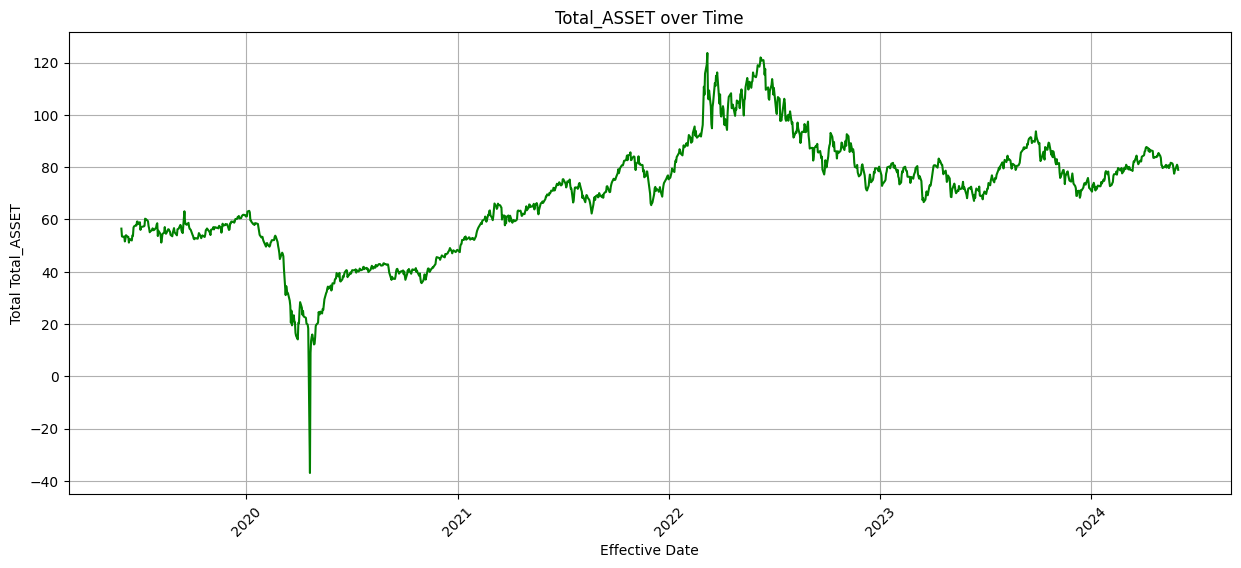

In [48]:
plt.figure(figsize=(15, 6))
plt.plot(df['DATE'], df['DCOILWTICO'],  linestyle='-',color='green')
plt.xlabel('Effective Date')
plt.ylabel('Total Total_ASSET')
plt.title('Total_ASSET over Time')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [49]:
df.set_index('DATE', inplace=True)

df.head()

,DCOILWTICO
DATE,
2019-05-30,56.47
2019-05-31,53.49
2019-06-03,53.25
2019-06-04,53.50
2019-06-05,51.57


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1248 entries, 2019-05-30 to 2024-05-21
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   DCOILWTICO  1248 non-null   float64
dtypes: float64(1)
memory usage: 19.5 KB


In [50]:
train = df[:770]
valid = df[770:1100]
test = df[1100:]

scaler = MinMaxScaler()

# Fit scaler on training data and transform all subsets
train_data = scaler.fit_transform(train[['DCOILWTICO']])
validate_data = scaler.transform(valid[['DCOILWTICO']])
test_data = scaler.transform(test[['DCOILWTICO']])

print("Train data size:", len(train_data))
print("Validation data size:", len(validate_data))
print("Test data size:", len(test_data))



Train data size: 770
Validation data size: 330
Test data size: 154


In [51]:
from keras.layers import Bidirectional
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 10 # Number of time steps to look back
X_train, y_train = create_sequences(train_data, seq_length)
X_val,y_val=create_sequences(validate_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

In [54]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout, Dense

# Define the model
model = Sequential()

# First Bidirectional LSTM layer
model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=(10, 1)))
model.add(Dropout(0.2))  # Dropout to prevent overfitting

# Second Bidirectional LSTM layer
model.add(Bidirectional(LSTM(64, return_sequences=False)))
model.add(Dropout(0.2)) r

# Dense layers
model.add(Dense(32, activation='relu'))
model.add(Dense(1))  # Output layer for single-step forecasting

# Model summary
model.summary()


optimizer = Adam(learning_rate=0.001)

model.compile(optimizer=optimizer, loss='mse')

# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=50, restore_best_weights=True)

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=200, batch_size=32, verbose=1, callbacks=[early_stopping])

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_13 (Bidirectional)     │ (None, 10, 256)             │         133,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 10, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_14 (Bidirectional)     │ (None, 128)                 │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 301,633 (1.15 MB)

 Trainable params: 301,633 (1.15 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.1183 - val_loss: 0.0061
Epoch 2/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0059 - val_loss: 0.0020
Epoch 3/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0033 - val_loss: 7.8646e-04
Epoch 4/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0028 - val_loss: 4.5271e-04
Epoch 5/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0023 - val_loss: 4.9925e-04
Epoch 6/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0020 - val_loss: 4.7146e-04
Epoch 7/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0024 - val_loss: 4.7429e-04
Epoch 8/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0021 - val_loss: 7.2852e-04
Epoch 9/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0020 - val_loss: 5.9527e-04
Epoch 10/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0024 - val_loss: 7.2028e-04
Epoch 11/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0022 - val_loss: 7.8780e-04
Epoch 12/200
24/

In [55]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [56]:
# Inverse transform the predictions and actual values
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
test_predict = scaler.inverse_transform(test_predict)
y_val = scaler.inverse_transform(y_test.reshape(-1, 1))


In [57]:
from sklearn.metrics import mean_squared_error
from math import sqrt

train_rmse = sqrt(mean_squared_error(y_train, train_predict))
test_rmse = sqrt(mean_squared_error(y_val, test_predict))

train_mse = mean_squared_error(y_train, train_predict)
test_mse = mean_squared_error(y_val, test_predict)

print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')
print(f'Train MSE: {train_mse}')
print(f'Test MSE: {test_mse}')

Train RMSE: 3.1706033531095437
Test RMSE: 1.4939734117285017
Train MSE: 10.052725622749481
Test MSE: 2.231956554951699


In [58]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# Calculate RMSE for training and test sets
train_rmse = sqrt(mean_squared_error(y_train, train_predict))
test_rmse = sqrt(mean_squared_error(y_val, test_predict))

print(f'Train RMSE: {train_rmse}')
print(f'The root mean squared error (RMSE) on test set: {test_rmse}')


Train RMSE: 3.1706033531095437
The root mean squared error (RMSE) on test set: 1.4939734117285017


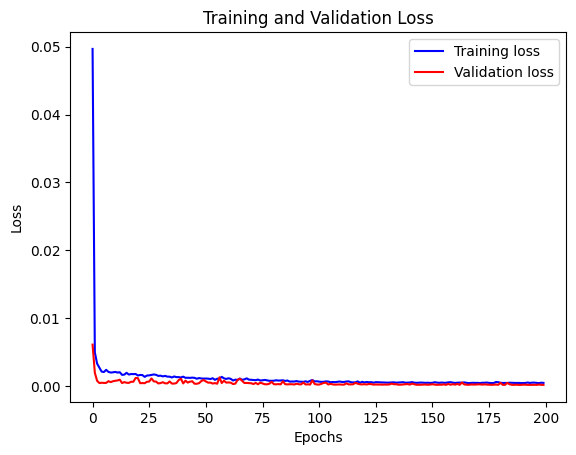

In [59]:
import matplotlib.pyplot as plt

def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(history, "Training and Validation Loss")



24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


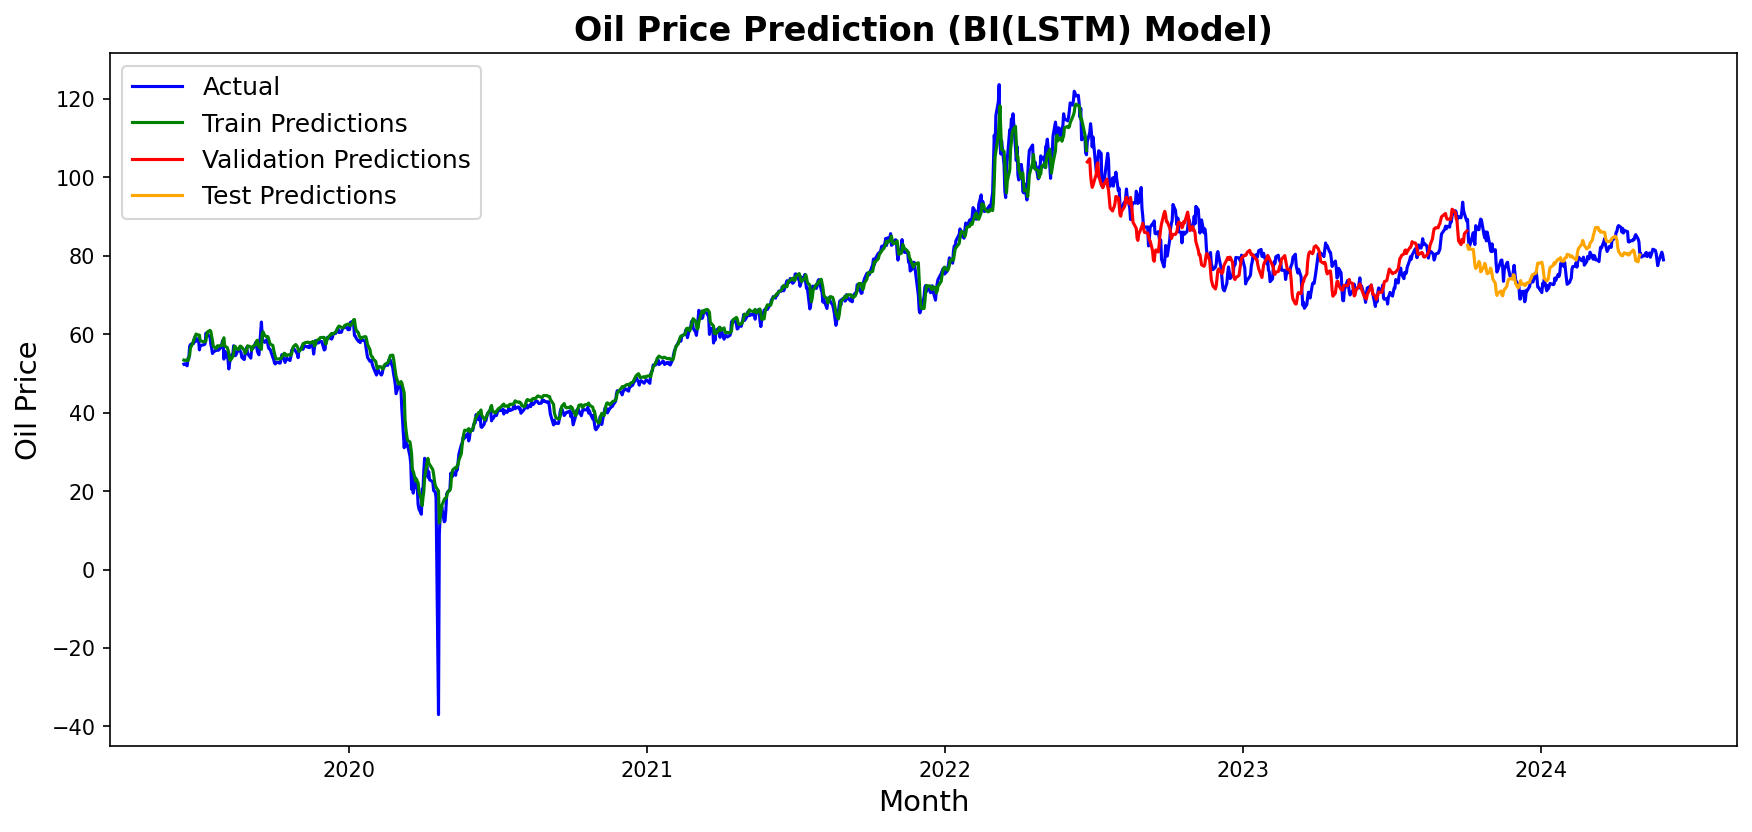

In [61]:
# Make predictions
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)
val_predictions = model.predict(X_val)

train_predictions = scaler.inverse_transform(train_predictions)
test_predictions = scaler.inverse_transform(test_predictions)
val_predictions = scaler.inverse_transform(val_predictions)


import matplotlib.pyplot as plt

# Adjust figure size and DPI for higher quality
plt.figure(figsize=(14, 6), dpi=150)  # Increased DPI for better resolution

# Plot the actual and predicted values with thicker lines and larger labels
plt.plot(df.index[seq_length:], df['DCOILWTICO'][seq_length:], label='Actual', color='blue', linewidth=1.5)

plt.plot(df.index[seq_length:seq_length+len(train_predictions)], train_predictions, label='Train Predictions', color='green', linewidth=1.5)

# Index ranges for validation and test predictions
val_pred_index = range(seq_length + len(train_predictions), seq_length + len(train_predictions) + len(val_predictions))
plt.plot(df.index[val_pred_index], val_predictions, label='Validation Predictions', color='red', linewidth=1.5)

test_pred_index = range(seq_length + len(train_predictions) + len(val_predictions), seq_length + len(train_predictions) + len(val_predictions) + len(test_predictions))
plt.plot(df.index[test_pred_index], test_predictions, label='Test Predictions', color='orange', linewidth=1.5)

# Set titles and labels with larger fonts
plt.title('Oil Price Prediction (BI(LSTM) Model)', fontsize=16, fontweight='bold')
plt.xlabel('Month', fontsize=14)
plt.ylabel('Oil Price', fontsize=14)

# Add a larger legend
plt.legend(loc='upper left', fontsize=12)

# Show the plot
plt.show()
